# testing the Build tree function of the NUTS sampler (much simplified)

In [93]:
import numpy as np
import copy
import matplotlib.pyplot as plt

from dataclasses import dataclass

# define some helper functions
def sample_momentum_vector(D=2, eta=0.05):
    means = np.zeros(D)
    cov = np.eye(D)
    return eta*(np.random.multivariate_normal(means, cov, 1).flatten())

def rotate_vector_2d(vector, phi_d):
    phi = phi_d*np.pi/180
    vec = vector.reshape(len(vector),1)
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    return (R@vec).flatten()
   
def check_uturn(sample_right, sample_left):
    theta_diff = sample_right.theta - sample_left.theta
    eval_ = (np.dot(theta_diff, sample_right.r) > 0) & (np.dot(theta_diff, sample_left.r) > 0)
    if eval_ == False: 
        print("U-turn between:", sample_right.time, sample_left.time)
        x, y = sample_left.theta[0], sample_left.theta[1]
        dx,dy = theta_diff[0], theta_diff[1]
        plt.arrow(x, y, dx, dy, color = "black", width=0.0001, head_width=0.0004)
        sample_right.plot_momentum(0.5)
        sample_left.plot_momentum(0.5)

    return (eval_)
        
iter_color_dict = {0:"black",1:"green",2:"blue",3:"orange",
                   4:"magenta",5:"darkblue", 6:"yellow", 
                   7:"lightgreen", 8:"black", 9:"blue"}

@dataclass
class nutsSample:
    time:              int = None
    iteration:         int = None
    theta:             list = None
    r:                 list = None
    valid:             bool = True
        
    def copy(self):
        return copy.deepcopy(self)
    
    def plot(self):
        self.plot_sample()
        self.plot_momentum()
        
    def plot_sample(self):
        c = iter_color_dict[(self.iteration)%10]
        plt.scatter(self.theta[0],self.theta[1],color=c)
        
    def plot_momentum(self, fac=1/10):
        x, y = self.theta[0], self.theta[1]
        dx, dy = self.r[0], self.r[1]
        plt.arrow(x, y, fac*dx, fac*dy, color = "red", width=0.00005, head_width=0.0002)
        
    def plot_text(self):
        plt.text(self.theta[0], self.theta[1], self.time)
        
    def leapfrog(self, eps):
        self.theta, self.r = leapfrog(self.theta, self.r, eps)
        
def leapfrog(theta, r, eps):
    phi_d = np.random.rand()*(40-(-40))-40
    phi_d = phi_d/1
    r = rotate_vector_2d(r, phi_d/2)
    theta = theta + eps*r
    r = rotate_vector_2d(r, phi_d/2)
    return (theta, r)
        
def build_naive_tree(sample, height, direction, eps, iteration):
    if height == 0:
        s = sample.copy()
        s.iteration = iteration
        s.time = sample.time+direction
        s.leapfrog(direction*eps)
        crit1 = np.random.rand() > 0.01
        if crit1==False: print("breaking cause sample at time:", s.time, "has too low probability")
        C1 = []
        C1.append(s)
        return(s, s, C1, crit1)
    else:
        s_minus, s_plus, C1, crit1 = build_naive_tree(sample, height-1, direction, eps, iteration)
        if direction == -1:
            s_minus, tmp, C2, crit2 = build_naive_tree(s_minus, height-1, direction, eps, iteration)
        else:
            tmp, s_plus, C2, crit2 = build_naive_tree(s_plus, height-1, direction, eps, iteration)
        crit1 = crit1*crit2*check_uturn(s_plus, s_minus)
        C1 = C1 + C2
        return (s_minus, s_plus, C1, crit1)
    
def naive_NUTS(eps, max_depth=15):
    s0 = nutsSample(time=0, iteration=0, theta=[0,0])
    s0.r = sample_momentum_vector()
    s_plus = s_minus = s0
    C = [s0]
    all_samples = [s0]
    j = 0
    crit = 1
    while crit == 1:
        d = 1 - 2*np.random.randint(2)
        if d == -1:
            s_minus, tmp, C1, crit1 = build_naive_tree(s_minus, j, d, eps, j+1)
        else: 
            tmp, s_plus, C1, crit1 = build_naive_tree(s_plus, j, d, eps, j+1)
        all_samples += C1
        if crit1 == 1: C = C + C1
        crit = crit1*check_uturn(s_plus, s_minus)
        j = j + 1
        if j==max_depth: 
            print("max iterations reached")
            break
        final_sample = sample_from_set(C)
    return (final_sample, C, all_samples)

def sample_from_set(C):
    return (C[np.random.randint(len(C))])

def samples_to_t_dict(samples):
    t_dict = {}
    for sample in samples:
        t_dict[sample.time] = sample
    return (t_dict)

U-turn between: -4 -11
U-turn between: 4 -11


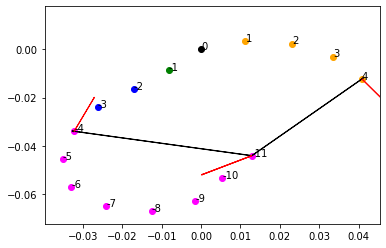

In [96]:
final_sample, C, a_s = naive_NUTS(0.4)

for sample in a_s:
    sample.plot_sample()
    sample.plot_text()

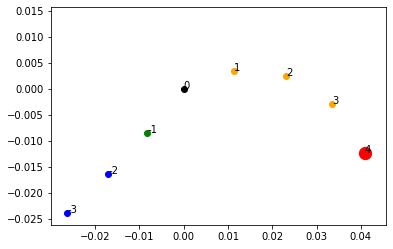

In [97]:
for sample in C:
    sample.plot_sample()
    sample.plot_text()

x,y = list(final_sample.theta)
plt.scatter(x,y,s = 150, c = "red")